In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
pd.set_option("display.max_columns",200)
from sklearn.metrics import r2_score


In [2]:
#TODO: Super upgraded walk forward optimization
#TODO: Data imputation

**Data Cleaning**

In [3]:
df = pd.read_csv('ListingsAndSales.csv')
#not sold flag
df['NotSoldFlag'] = 0
df.loc[df['SalesDate'].isnull() == True,'NotSoldFlag'] = 1

#convert ListingDate and SalesDate to date
df.ListingDate = pd.to_datetime(df.ListingDate)

df.SalesDate = df.SalesDate.fillna('2015-04-07')
df.SalesDate = pd.to_datetime(df.SalesDate)

#calculate days it took to sell the listing if it's sold
df['DaysSold'] = (df.SalesDate - df.ListingDate).dt.days.astype(float)
#add one to DaysSold to prevent 0 when taking the log afterwards
df['DaysSold'] = df['DaysSold'] + 1

#loop through the variables and replace missing values with avg and create dummy variables
col_dates = ['ListingDate', 'SalesDate']
for i in df.columns.values:
    if not i in col_dates:
        if df[i].isnull().sum(axis = 0) > 0:
            avg_i = df[i][df[i].isnull() == False].mean()
            df[i + "_mv"] = (df[i].isnull())*1
            df[i] = df[i].fillna(avg_i)

#convert ListingDate to the day of the year, since all the dates are within a year
df['ListingDay'] = (df.ListingDate - df.ListingDate.min()).dt.days

#drop SalesDate variable


**Split Data into Training Set and Test Set**

In [4]:
df['NotSoldFlag'].mean()

0.6864035087719298

In [5]:
X = df.drop(['DaysSold', 'ListingDate', 'SalesDate', 'NotSoldFlag'],axis = 1)
Y = df[['DaysSold']].as_matrix().astype(np.float32)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns).as_matrix().astype(np.float32)
sold = df['NotSoldFlag'].as_matrix().astype(np.float32)

n_samples = Y.shape[0]
n_features = X.shape[1]




In [6]:
def apply_clipped_optimizer(opt_fcn,
                            loss,
                            clip_norm=.1,
                            clip_single=.03,
                            clip_global_norm=False):
  gvs = opt_fcn.compute_gradients(loss)

  if clip_global_norm:
    gs, vs = zip(*[(g, v) for g, v in gvs if g is not None])
    capped_gs, grad_norm_total = tf.clip_by_global_norm([g for g in gs],
                                                        clip_norm)
    capped_gvs = list(zip(capped_gs, vs))
  else:
    grad_norm_total = tf.sqrt(
        tf.reduce_sum([
            tf.reduce_sum(tf.square(grad)) for grad, var in gvs
            if grad is not None
        ]))
    capped_gvs = [(tf.clip_by_value(grad, -1 * clip_single, clip_single), var)
                  for grad, var in gvs if grad is not None]
    capped_gvs = [(tf.clip_by_norm(grad, clip_norm), var)
                  for grad, var in capped_gvs if grad is not None]

  optimizer = opt_fcn.apply_gradients(
      capped_gvs, global_step=tf.train.get_global_step())

  return optimizer, grad_norm_total

In [7]:
#For numeric stability
EPSILON = 1e-10


class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes
        self.sold = tf.placeholder(tf.float32, shape = (None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))
        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)
        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))
        
        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) * (1-self.sold) + self.sold)
        loss_numerator = tf.reduce_sum(tf.square(self.y - self.output) * self.loss_indicator)
        loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
        self.loss = loss_numerator/loss_denominator
        opt_fcn = tf.train.AdamOptimizer()
        self.optimizer = apply_clipped_optimizer(opt_fcn, self.loss)
        

In [8]:

tf.reset_default_graph()      
        
model = Model(n_features, layer_sizes = [32, 32,])

sess = tf.Session()
sess.run(tf.global_variables_initializer())

X_test = X_train = X
Y_train = Y_test = Y
sold_train = sold_test = sold
trn_losses = []
val_losses = []
r2_scores = []
bs=64
num_batches = (n_samples // bs) + 1
for epoch in range(100):
    trn_loss = []
    order = np.arange(n_samples)
    np.random.shuffle(order)
    for itr in range(n_samples//bs):
        rows = order[itr*bs:(itr+1)*bs]
        if itr+1 == num_batches:
            rows = order[itr*bs:]
        X_active, Y_active, Sold_active = X_train[rows,:], Y_train[rows], sold_train[rows]
        feed_dict = {model.x: X_active,
                model.y: Y_active,
                model.sold: Sold_active}
        _, loss, yhat = sess.run([model.optimizer, model.loss, model.output], feed_dict)
        trn_loss.append(loss)
    if epoch % 2 == 0:
        trn_loss_mean = np.mean(trn_loss)
        trn_losses.append(trn_loss_mean)
        feed_dict = {model.x: X_test,
                    model.y: Y_test,
                    model.sold: sold_test}
        val_loss, yhat = sess.run([model.loss, model.output], feed_dict)
        val_losses.append(val_loss)
        r2_scores.append(r2_score(Y_test, yhat))
    if epoch % 10 == 0:
        print( 'epoch:', epoch, 'train loss: ', trn_loss_mean, 'val loss: ',val_loss)
y_tst_predict = sess.run(model.output, {model.x: X_test})

epoch: 0 train loss:  1213.85 val loss:  1121.11
epoch: 10 train loss:  69.3238 val loss:  66.347
epoch: 20 train loss:  51.2745 val loss:  50.1268
epoch: 30 train loss:  45.0404 val loss:  44.7469
epoch: 40 train loss:  41.9306 val loss:  41.5839
epoch: 50 train loss:  38.9849 val loss:  39.1433
epoch: 60 train loss:  37.4565 val loss:  37.087
epoch: 70 train loss:  35.8448 val loss:  35.8651
epoch: 80 train loss:  35.5389 val loss:  34.2937
epoch: 90 train loss:  34.9963 val loss:  33.6411


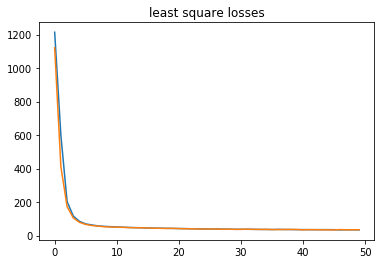

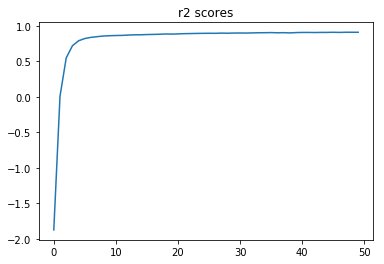

In [9]:
plt.plot(trn_losses, label = 'train loss')
plt.plot(val_losses, label = 'test loss')
plt.title('least square losses')
plt.show()
plt.plot(r2_scores, label='validation r2_scores')
plt.title('r2 scores')
plt.show()

In [10]:
df[['ListingDate', 'SalesDate']].describe()

,ListingDate,SalesDate
count,4104,4104
unique,98,34
top,2015-04-03 00:00:00,2015-04-07 00:00:00
freq,125,2817
first,2014-12-31 00:00:00,2015-01-12 00:00:00
last,2015-04-07 00:00:00,2015-04-07 00:00:00


In [11]:
X = df_active.drop(['DaysSold', 'ListingDate', 'SalesDate'],axis = 1)
Y = df_active[['DaysSold']]

n_samples = Y.shape[0]
train_size = n_samples * 3 // 4 
X_train, Y_train = [df.iloc]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

#for neural network
Y_nn = pd.DataFrame(df['DaysSold'])
X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X, Y_nn, train_size = 0.75)

scaler = StandardScaler()
X_train_scaled_nn = pd.DataFrame(scaler.fit_transform(X_train_nn), columns = X_train.columns)
X_test_scaled_nn = pd.DataFrame(scaler.transform(X_test_nn), columns = X_test.columns)

NameError: name 'df_active' is not defined

**Modeling**

In [ ]:
#run linear regression
linear = LinearRegression().fit(X_train_scaled, Y_train)
linear_pred_test = np.exp(linear.predict(X_test_scaled)) - 1
linear_pred_train = np.exp(linear.predict(X_train_scaled)) - 1

#customized evaluation metrics
#when Y is larger than DaysSold, no error
X_train_linear_pred = pd.merge(X_train_scaled, pd.DataFrame(linear_pred_train, columns = ['Y'], index = X_train_scaled.index), how = 'inner', left_index= True, right_index = True)
X_train_linear_pred = pd.merge(X_train_linear_pred, pd.DataFrame(df['DaysSold']), how = 'inner', left_index = True, right_index = True)

X_train_linear_pred['Err_Val'] = np.square(X_train_linear_pred['DaysSold'] - X_train_linear_pred['Y'])
X_train_linear_pred['Err_Ind'] = (X_train_linear_pred['NotSoldFlag'] == 0) + ((X_train_linear_pred['NotSoldFlag'] == 1) + (X_train_linear_pred['Y'] <= X_train_linear_pred['DaysSold']))
X_train_linear_pred['Eval'] = X_train_linear_pred['Err_Val'] * X_train_linear_pred['Err_Ind']
linear_mse_train = X_train_linear_pred['Eval'].mean()


X_test_linear_pred = pd.merge(X_test_scaled, pd.DataFrame(linear_pred_test, columns = ['Y'], index = X_test_scaled.index), how = 'inner', left_index= True, right_index = True)
X_test_linear_pred = pd.merge(X_test_linear_pred, pd.DataFrame(df['DaysSold']), how = 'inner', left_index = True, right_index = True)

X_test_linear_pred['Err_Val'] = np.square(X_test_linear_pred['DaysSold'] - X_test_linear_pred['Y'])
X_test_linear_pred['Err_Ind'] = (X_test_linear_pred['NotSoldFlag'] == 0) + \
    ((X_test_linear_pred['NotSoldFlag'] == 1) + (X_test_linear_pred['Y'] <= X_test_linear_pred['DaysSold']))
X_test_linear_pred['Eval'] = X_test_linear_pred['Err_Val'] * X_test_linear_pred['Err_Ind']
linear_mse_test = X_test_linear_pred['Eval'].mean()

print('Mean squared error for linear regression on train set is {}.'.format(linear_mse_train))
print('Mean squared error for linear regression on test set is {}.'.format(linear_mse_test))

In [ ]:
X_train_scaled_features = X_train_scaled_nn.drop(['NotSoldFlag'], axis = 1)
X_test_scaled_features = X_test_scaled_nn.drop(['NotSoldFlag'], axis = 1)

In [ ]:
#run neural network with customized one-sided loss function
def lrelu(x):
    return tf.maximum(x, 1e-1*x)
tf.reset_default_graph()

class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes
        self.sold = tf.placeholder(tf.float32, shape = (None))
        self.input_layer = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))
        prev_layer = self.input_layer/10
        for idx, layer in enumerate(layer_sizes):
            next_layer = tf.layers.dense(prev_layer, layer, name='layer'+str(idx))
            prev_layer = lrelu(next_layer)
        self.output = tf.nn.softplus(tf.layers.dense(prev_layer, 1, name='output'))
        
        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) * (1-self.sold) + self.sold) + 1e-8
        
        self.loss = tf.reduce_sum(tf.square(self.y - self.output) * self.loss_indicator) / (tf.reduce_sum(self.loss_indicator))
        grad_clipping = 0
        if grad_clipping:
            optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
            gvs = optimizer.compute_gradients(self.loss)
            self.grad_norm = tf.reduce_mean([tf.reduce_mean(tf.square(grad)) for grad, var in gvs if grad is not None])
            clip_norm = 100
            clip_single = 1
            capped_gvs = [(tf.clip_by_value(grad, -1*clip_single,clip_single), var)
                          for grad, var in gvs if grad is not None]
            capped_gvs = [(tf.clip_by_norm(grad, clip_norm), var) for grad, var in capped_gvs if grad is not None]
            self.optimizer = optimizer.apply_gradients(capped_gvs)
        else:
            self.grad_norm = 'NotUsed'
            self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(self.loss)
        
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
model = Model(X_train_scaled_features.shape[1], layer_sizes = [])

In [ ]:
101 // 100

In [ ]:
X_trn, Y_trn = X_train_scaled_features.as_matrix().astype(np.float32), Y_train_nn.as_matrix().astype(np.float32)
X_tst, Y_tst = X_test_scaled_features.as_matrix().astype(np.float32), Y_test_nn.as_matrix().astype(np.float32)
sold = X_train['NotSoldFlag'].as_matrix().astype(np.float32)
sold_tst = X_test['NotSoldFlag'].as_matrix().astype(np.float32)
trn_loss = []
num_rows = X_trn.shape[0]
bs=100
num_batches = (num_rows // bs) + 1
for epoch in range(100):
    order = np.arange(num_rows)
    np.random.shuffle(order)
    for itr in range(num_rows//bs):
        rows = order[itr*bs:(itr+1)*bs]
        if itr+1 == num_batches:
            rows = order[itr*bs:]
        X_active, Y_active, Sold_active = X_trn[rows,:], Y_trn[rows], sold[rows]
        feed_dict = {model.input_layer: X_active,
                model.y: Y_active,
                model.sold: Sold_active}
        _, loss, yhat = model.sess.run([model.optimizer, model.loss, model.output], feed_dict)
        trn_loss.append(loss)
    if epoch % 10 == 0:
        print('train loss: ',np.mean(trn_loss), 'epoch:', epoch)
        trn_loss = []
        feed_dict = {model.input_layer: X_tst,
                    model.y: Y_tst,
                    model.sold: sold_tst}
        val_loss = model.sess.run(model.loss, feed_dict)
        print('val loss: ',val_loss, 'itr:', itr)
y_tst_predict = model.sess.run(model.output, {model.input_layer: X_tst})

In [ ]:
y_tst_predict